<h1>A Project on Breast Cancer Diagnostics - To get certain insights</h1>

### Import Relevant Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import datetime

In [4]:
#Load our Dataset

bc_dataset = pd.read_csv("Breast_Cancer.csv", encoding = "ISO-8859-1")

In [7]:
#Let's inspect our data and get a feel of what we are working with
print(bc_dataset.head())
print(bc_dataset.tail())

   Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   
4   47  White        Married       T2      N1       IIB   

               differentiate Grade   A Stage  Tumor Size Estrogen Status  \
0      Poorly differentiated     3  Regional           4        Positive   
1  Moderately differentiated     2  Regional          35        Positive   
2  Moderately differentiated     2  Regional          63        Positive   
3      Poorly differentiated     3  Regional          18        Positive   
4      Poorly differentiated     3  Regional          41        Positive   

  Progesterone Status  Regional Node Examined  Reginol Node Positive  \
0            Positive                      24                      1   
1            Positive                      1

In [6]:
#Let's get the column names and export to chatgpt to get an understanding of the data we are working with

bc_dataset.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [8]:
#before we dig deep.., let's just drop some columns. some columns that would be dropped are based on the following assumptions:
# Marital Status: Assume all women have similar status and relationship life is not a contributing factor
#Race: Assume all women belong to the same race. i.e. a homogenous race in this regards
#A stage: Essentially most of the A stages here are regional

In [9]:
bc_dataset_cp = bc_dataset.copy(deep = True)

In [11]:
bc_dataset_cp.drop(['Race', 'Marital Status', 'A Stage'], axis = 1, inplace= True)

In [54]:
#Let's get a feel of the data types and information of our dataset

print(bc_dataset_cp.info())

#let's also see our data again:

print(bc_dataset_cp.head(10))

print(bc_dataset_cp.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     4024 non-null   int64 
 1   t_stage                 4024 non-null   object
 2   n_stage                 4024 non-null   object
 3   6th_stage               4024 non-null   object
 4   differentiate           4024 non-null   object
 5   grade                   4024 non-null   object
 6   tumor_size              4024 non-null   int64 
 7   estrogen_status         4024 non-null   object
 8   progesterone_status     4024 non-null   object
 9   regional_node_examined  4024 non-null   int64 
 10  regional_node_positive  4024 non-null   int64 
 11  survival_months         4024 non-null   int64 
 12  status                  4024 non-null   object
 13  status_in_digits        4024 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 440.3+ KB
None
   a

In [14]:
#before we continue..., are there any loopholes in our dataset
#i mean is any null value present

In [17]:
bc_dataset_cp.isnull().sum()
#alright.., no null values present.., it's clean.., we can proceed

Age                       0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [21]:
#feature-engineering --- for the sake of this transformation.., we want to convert the status to 1 for alive and 0 for dead
#this extra column would be necessary for machine learning., as text might be intrinsically confusing

bc_dataset_cp.Status.unique()

#alright.., with this we can write a lambda function for mapping Alive to 1 and Dead to 0

status_converter = lambda x: 1 if x == 'Alive' else 0

In [22]:
bc_dataset_cp['status_in_digits'] = bc_dataset_cp['Status'].map(status_converter)

In [24]:
bc_dataset_cp.columns

Index(['Age', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade',
       'Tumor Size', 'Estrogen Status', 'Progesterone Status',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months',
       'Status', 'status_in_digits'],
      dtype='object')

In [28]:
#column names modification
#let's use underscore for spaces
#let's swap case from sentence case to lower cse

bc_dataset_cp.rename(columns= {'Age':'age', 'T Stage ':'t_stage','N Stage':'n_stage', '6th Stage':'6th_stage',
                               'Grade':'grade', 'Tumor Size':'tumor_size', 'Estrogen Status':'estrogen_status',
                               'Progesterone Status':'progesterone_status', 'Regional Node Examined':'regional_node_examined',
                               'Reginol Node Positive':'regional_node_positive', 'Survival Months':'survival_months',
                               'Status':'status'}, inplace = True)

In [29]:
bc_dataset_cp.columns

Index(['age', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'grade',
       'tumor_size', 'estrogen_status', 'progesterone_status',
       'regional_node_examined', 'regional_node_positive', 'survival_months',
       'status', 'status_in_digits'],
      dtype='object')

In [30]:
#let's not get too ahead of ourselves.., but we can take a look at the data types that are numbers and see if there is 
#any correlation between them

In [63]:
corr_values_numeric= (bc_dataset_cp[(bc_dataset_cp.columns[bc_dataset_cp.dtypes == 'int64'])]).corr()
#from what i can see it seems there isn't any relationship.., we can employ the heatmap of seaborn to visualize this

In [64]:
corr_values_numeric

,age,tumor_size,regional_node_examined,regional_node_positive,survival_months,status_in_digits
age,1.000000,-0.077215,-0.033345,0.012586,-0.009390,-0.055921
tumor_size,-0.077215,1.000000,0.104352,0.242322,-0.086901,-0.134205
regional_node_examined,-0.033345,0.104352,1.000000,0.411580,-0.022054,-0.034772
regional_node_positive,0.012586,0.242322,0.411580,1.000000,-0.135214,-0.256638
survival_months,-0.009390,-0.086901,-0.022054,-0.135214,1.000000,0.476514
status_in_digits,-0.055921,-0.134205,-0.034772,-0.256638,0.476514,1.000000


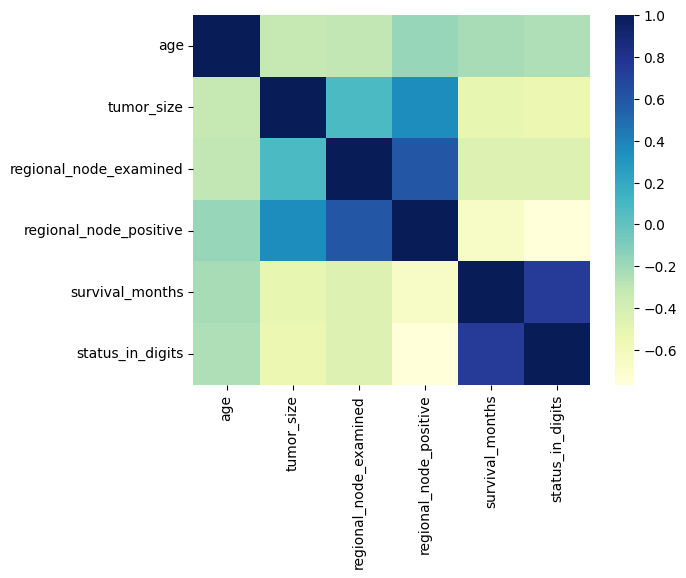

In [65]:
sns.heatmap(data = corr_values_numeric.corr(), cmap = 'YlGnBu')
plt.show()


#observations: it's quite obvious: but we know that there is a correlation somewhere around 0.5 with the survival months
#this might be misleading as the status is not dead.., let's reevaluate for a status of dead and see what our results tells us

C:\Users\richmond\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\richmond\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\richmond\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='status_in_digits', ylabel='count'>

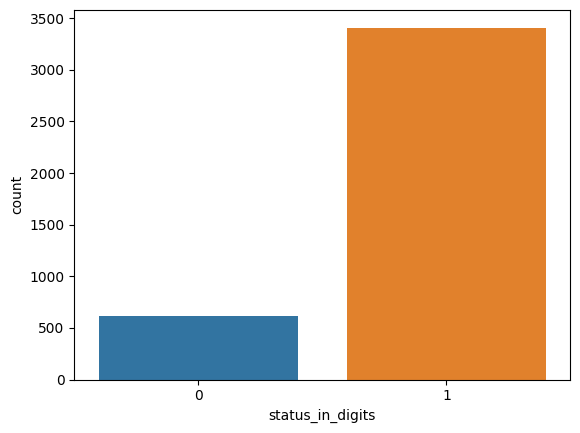

In [67]:
#alright.., let's start with status and survival months...
#let's see a count plot of this

sns.countplot(data = bc_dataset_cp, x= 'status_in_digits')

In [71]:
bc_dataset_cp.groupby('status_in_digits')['survival_months'].sum()

status_in_digits
0     28096
1    258807
Name: survival_months, dtype: int64